# Apache Spark and High Energy Physics Data Analysis
## An example using LHCb open data

This notebook is an example of how to use Spark to perform a simple analysis using high energy physics data from a LHC experiment.  
The exercises, figures and data are from original work developed and published by the **LHCb collaboration** as part of the **opendata** and outreach efforts (see credits below).  
**Prerequisites** - This work is intended to be accessible to an audience with some familiarity with data analysis in Python and an interest in particle Physics at undergraduate level.  
**Technology** - The focus of this notebook is as much on tools and techniques as it is on physics: **Apache Spark** is used for reading and analyzing high energy physics (HEP) data using Python with Pandas and Jupyter notebooks.

**Credits:**
   * The original text of this notebook, including all exercises, analysis, explanations and data have been developed by the LHCb collaboration and are authored and shared by the LHCb collaboration in their opendata project at:  
      * https://github.com/lhcb/opendata-project
      * http://www.hep.manchester.ac.uk/u/parkes/LHCbAntimatterProjectWeb/LHCb_Matter_Antimatter_Asymmetries/Homepage.html 
      * https://cds.cern.ch/record/1994172?ln=en  
      
   * The library for reading physics data stored using the popular [ROOT format](https://en.wikipedia.org/wiki/ROOT) has been developed by [DIANA-HEP](http://diana-hep.org/) and [CMS Big Data project](https://cms-big-data.github.io/). See also the code repository at:  
      * https://github.com/diana-hep/spark-root

   * The Spark code in this notebook has been developed in the context of the CERN Hadoop and Spark service.   
Contact email: Luca.Canali@cern.ch

# Introduction and setup of the lab environemnt

There are a few different ways that you can to run Python and Spark in a notebook environment.
The following are instructions to set up a lab environemnt on a low-end system (small VM or laptop).
If you have already set up Spark on a local machine or a cluster, you can just start the Jupyter notebook.   
**Note for CERN users**: if you are using [CERN SWAN service](https://swan.web.cern.ch/) (hosted Jupyter notebooks) to run this, you can move on to the next cell.

### Instructions to get started with Jupyter notebooks and PySpark on a standalone system:

* Setup the Python environment, for example download and install Anaconda https://www.continuum.io/downloads
   * version used/tested for this notebook: Anaconda 4.4.0 for Python 2.7

* Set up Spark
   * simply run `pip install pyspark` 
   * as an alternative download Spark from http://spark.apache.org/downloads.html
   * note: Spark version used for testing this notebook: Spark 2.2.0 and 2.1.1

* Start the Jupyter notebook
```python
jupyter-notebook --ip=`hostname` --no-browser
```

* Point your browser to the URL as prompted   
* Open this notebook 

In [1]:
# This starts the Spark Session
# Note: Shift-Enter can be used to run Jupyter cells
# These instructions rely on internet access to download the spark-root package from Maven Central

from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .appName("LHCb Open Data with Spark") \
        .config("spark.jars.packages", "org.diana-hep:spark-root_2.11:0.1.11") \
        .getOrCreate()

In [2]:
# Test that Spark SQL works

sql = spark.sql
sql("select 'Hello World!'").show()

+------------+
|Hello World!|
+------------+
|Hello World!|
+------------+



# Get the data: download from CERN open data portal

Download the data for the exercises from the CERN opendata portal:
More info on the CERN opedata initiative at http://opendata.cern.ch/about   
**Note for CERN users** using CERN SWAN (hosted notbooks): you don't need to download data (see next cell)

Simulation data (~2 MB) - you need this file only for the first part of the notebook: working on simulation data   
http://opendata.cern.ch/eos/opendata/lhcb/AntimatterMatters2017/data/PhaseSpaceSimulation.root   

Measurement data (~1 GB) - you will need these files for the second part of the notebook: working on real data    
http://opendata.cern.ch/eos/opendata/lhcb/AntimatterMatters2017/data/B2HHH_MagnetDown.root   
http://opendata.cern.ch/eos/opendata/lhcb/AntimatterMatters2017/data/B2HHH_MagnetUp.root   

**Notes:**   
On Linux you can use [wget](https://www.gnu.org/software/wget/) to download the files  
If you run Spark on a standalone system or VM, simply put the data in the local filesystem.  
If you are using Spark on a cluster, you should put the data in a cluster filesystem, for example HDFS.  

In [3]:
# Edit this with the path to the data, with a trainling "/" 
# see above at "get the data" for details on how to download

# CERN SWAN users can find data already in EOS
data_directory = "/eos/opendata/lhcb/AntimatterMatters2017/data/"

# Uncomment and edit the path for locally downloaded data
# data_directory = "/home/luca/misc/opendata-project/data/"


# Measuring Matter Antimatter Asymmetries at the Large Hadron Collider

![](http://lhcb-public.web.cern.ch/lhcb-public/en/LHCb-outreach/multimedia/LHCbDetectorpnglight1.png)

# Getting Started

Note: the original text of this exercise in the form relased by LHCb can be found at https://github.com/lhcb/opendata-project
____

<b> Welcome to the first guided LHCb Open Data Portal project! </b>

<div align="justify">Here you will be able to analyse data taken by the Large Hadron Collider (LHC) at CERN. The aim of this study is for you to be able to search for differences in the behaviour of matter and [antimatter](https://en.wikipedia.org/wiki/Antimatter). This project will enable you to carry out your own data analysis at a level similar to that of CERN research. This project does not require a detailed knowledge of particle physics. It is most suitable for people with a scientific and mathematical background equivalent to that required for applying for university entrance in a science, technology engineering or mathematics discipline. Some previous familiarity with computer programming would also be advantageous. Additional theoretical information or programming knowledge you might need is provided as the project progresses.</div>

Before you start, you might find it helpful to find out more about matter antimatter asymmetries, what we hope to learn by studying them, and how we can detect them with experiments such as the LHCb experiment at CERN.

Here are some details that relate directly to this project:
 - What is the [particle physics focus](https://github.com/lhcb/opendata-project/tree/master/Background-Information-Notebooks/ProjectIntro.ipynb) of this experiment? and what will I study in this project?
 - How does the LHCb [detector](https://github.com/lhcb/opendata-project/tree/master/Background-Information-Notebooks/DetectorSoftwareDataSample.ipynb) record the data?


## Reading simulation data

In order to get started and check the first code that you will be writing works correctly it is best to start by analysing simulated data rather than real data from the LHC. The real data contains not only the type of events that you wish to analyse, known as the 'signal', but also events that can fake these, known as 'background'. The real data measurements are also limited by the resolution of the detector. The simplified simulation data provided here contains only the signal events and provides the results that would be obtained for a perfect detector.

IMPORTANT: For every code box with code already in it, like the one below you must click in and press shift+enter to run the code.

If the `In [x]:` to the left of a codebox changes to `In [*]:` that means the code in that box is currently running

In [4]:
# Boilerplate
from __future__ import print_function
from __future__ import division

%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0)

Populating the interactive namespace from numpy and matplotlib


If you want help with coding there is in addition to the [example code](https://github.com/lhcb/opendata-project/tree/master/Example-Analysis.ipynb), some hints within each section and a [function reference list](https://github.com/lhcb/opendata-project/tree/master/Background-Information-Notebooks/FunctionReferences.pdf) 

This is a [reference to Spark DataFrames and SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html)

In [5]:
# Let us now load the simulated data
# as detailed above you should have downloaded locally the simulation data from 
# http://opendata.cern.ch/eos/opendata/lhcb/upload/AntimatterMatters2017/data/PhaseSpaceSimulation.root

# This reads the data into a Spark DataFrame using the spark-root connector
sim_data_df = spark.read.format("org.dianahep.sparkroot").load(data_directory + "PhaseSpaceSimulation.root")

# This registers the Spark DataFrame as a temporary view and will allow the use of SQL, used later in the notebook
sim_data_df.createOrReplaceTempView("sim_data") 

sim_data_df.cache() # it is a small dataset (~2 MB) so we can afford to cache it
sim_data_df.count()

50000

<div align="justify">Now that you can access the data, you can use a number of functions which can help you analyse it. You can find these functions in the libraries at the top of the page. Try to make a table of some of the information within your data file so that you can get a feel of the typical values for data in the set. Understanding the range of values for different variables will help with plotting graphs.</div>

The data contains information about 'events' that were observed in the detector. An event refers to the particles produced when an interaction took place when two proton are collided at the LHC. The data you have includes information about particles observed in the detector after each collision. If you think of the data as a table, each row of the table is the results from a different collision. The columns of the table are different quantities measured about the particles produced in the collision. 

We are interested in analysing the decays of particles called B<sup>+</sup> or B<sup>-</sup> mesons decaying into three other mesons called kaons (K<sup>+</sup> or K<sup>-</sup>). The events you have been given are those in which this process may have occurred. The detector has been used to reconstruct tracks that may have come from the kaons. You are given the measured momenta, charge, and likelihood of the tracks being kaons. You are given information for three tracks in each event, the ones that could be the three kaons that a B<sup>+</sup> or B<sup>-</sup> meson has decayed into. The following information is available about each event: [information list](https://github.com/lhcb/opendata-project/tree/master/Background-Information-Notebooks/EventData.ipynb)

In [6]:
# Display the first 10 rows in the sim_data_df Spark DataFrame

sim_data_df.limit(10).toPandas() # use pandas only for visualization

,B_FlightDistance,B_VertexChi2,H1_PX,H1_PY,H1_PZ,H1_ProbK,H1_ProbPi,H1_Charge,H1_IPChi2,H1_isMuon,...,H2_IPChi2,H2_isMuon,H3_PX,H3_PY,H3_PZ,H3_ProbK,H3_ProbPi,H3_Charge,H3_IPChi2,H3_isMuon
0,0.0,1.0,3551.84,1636.96,23904.14,1.0,0.0,-1,1.0,0,...,1.0,0,36100.40,16546.83,295600.61,1.0,0.0,-1,1.0,0
1,0.0,1.0,-2525.98,-5284.05,35822.00,1.0,0.0,1,1.0,0,...,1.0,0,-8648.32,-16617.56,98535.13,1.0,0.0,-1,1.0,0
2,0.0,1.0,-700.67,1299.73,8127.76,1.0,0.0,-1,1.0,0,...,1.0,0,-13483.34,10860.77,79787.59,1.0,0.0,1,1.0,0
3,0.0,1.0,3364.63,1397.30,222815.29,1.0,0.0,1,1.0,0,...,1.0,0,1925.16,-551.12,40420.96,1.0,0.0,1,1.0,0
4,0.0,1.0,-581.66,-1305.24,22249.59,1.0,0.0,-1,1.0,0,...,1.0,0,-2820.04,-8305.43,250130.00,1.0,0.0,-1,1.0,0
5,0.0,1.0,112.84,-13297.98,51882.87,1.0,0.0,1,1.0,0,...,1.0,0,-440.95,-13699.42,71163.14,1.0,0.0,-1,1.0,0
6,0.0,1.0,5558.97,3913.52,56981.08,1.0,0.0,-1,1.0,0,...,1.0,0,3457.70,780.13,28716.94,1.0,0.0,1,1.0,0
7,0.0,1.0,-15208.03,-1783.93,265210.55,1.0,0.0,1,1.0,0,...,1.0,0,-4478.67,-164.39,71498.09,1.0,0.0,1,1.0,0
8,0.0,1.0,-109.04,8239.25,191486.94,1.0,0.0,-1,1.0,0,...,1.0,0,-2083.59,11359.35,192297.67,1.0,0.0,-1,1.0,0
9,0.0,1.0,15175.26,93142.09,379269.30,1.0,0.0,1,1.0,0,...,1.0,0,3295.84,24950.02,105990.48,1.0,0.0,-1,1.0,0


In [7]:
# Print the schema of the simulation data

sim_data_df.printSchema() # the schema of the root file

root
 |-- B_FlightDistance: double (nullable = true)
 |-- B_VertexChi2: double (nullable = true)
 |-- H1_PX: double (nullable = true)
 |-- H1_PY: double (nullable = true)
 |-- H1_PZ: double (nullable = true)
 |-- H1_ProbK: double (nullable = true)
 |-- H1_ProbPi: double (nullable = true)
 |-- H1_Charge: integer (nullable = true)
 |-- H1_IPChi2: double (nullable = true)
 |-- H1_isMuon: integer (nullable = true)
 |-- H2_PX: double (nullable = true)
 |-- H2_PY: double (nullable = true)
 |-- H2_PZ: double (nullable = true)
 |-- H2_ProbK: double (nullable = true)
 |-- H2_ProbPi: double (nullable = true)
 |-- H2_Charge: integer (nullable = true)
 |-- H2_IPChi2: double (nullable = true)
 |-- H2_isMuon: integer (nullable = true)
 |-- H3_PX: double (nullable = true)
 |-- H3_PY: double (nullable = true)
 |-- H3_PZ: double (nullable = true)
 |-- H3_ProbK: double (nullable = true)
 |-- H3_ProbPi: double (nullable = true)
 |-- H3_Charge: integer (nullable = true)
 |-- H3_IPChi2: double (nullable = 

# Invariant mass reconstruction

## Aims:
* Plot a histogram of the momentum of one of the kaon candidates
* Calculate the energy of each of the kaon candidates
* Plot the invariant masses of the B<sup>+</sup> or B<sup>-</sup> mesons___

### Plotting a feature:

You can plot any feature of the data in a histogram. Choose any suitable binning that allows you to observed the distribution of the variable clearly. Try making a histogram for the first kaon candidate's momentum x-component (H1_PX):

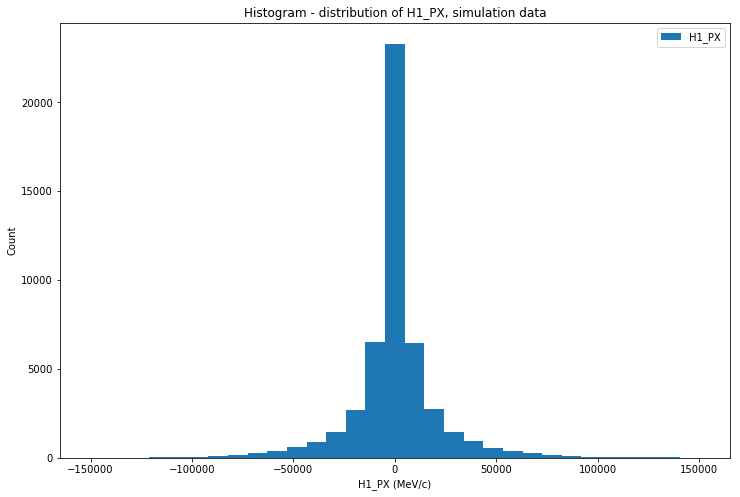

In [8]:
# Plot a histogram of the distribution of the H1_PX variable, using Pandas

# This is a basic solution that  moves all the data from the Spark DataFrame 
# into a Python Pandas DataFrame. It's OK for small sata sets, but it has scalability issues

h1px_data = sim_data_df.select("H1_PX").toPandas() # select H1_PX data and moves it to Pandas
h1px_data.plot.hist(bins=31, range=[-150000, 150000], title="Histogram - distribution of H1_PX, simulation data")
xlabel('H1_PX (MeV/c)')
ylabel('Count');

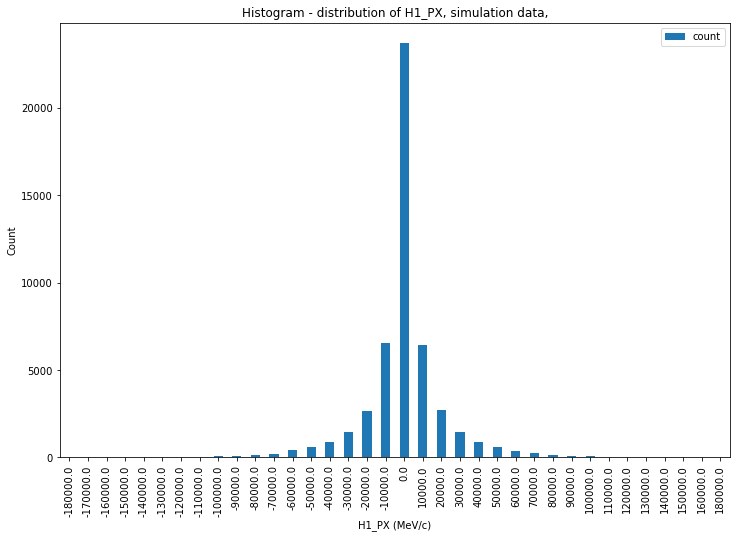

In [9]:
# This example computes and plots a histogram of the H1_PX data, similarly to the previous cell
# The notable difference is that Spark SQL is used to compute the aggregations and only the final result
# is  returned and transformed into a Pandas DataFrame, just for plotting. 
# This vesion can scale on a cluster for large datasets, while the previous version requires to fetch all data into Pandas

histogram_h1px_df = sql("""
     select round(H1_PX/10000,0) * 10000 as bin, count(1) as count
     from sim_data 
     group by round(H1_PX/10000,0) order by 1
     """)
histogram_h1px_pandas = histogram_h1px_df.toPandas()
histogram_h1px_pandas.plot.bar(x='bin', y='count', title="Histogram - distribution of H1_PX, simulation data,")
xlabel('H1_PX (MeV/c)')
ylabel('Count');

In [10]:
# This is the same query used for the histogram displayed above. 
# It is here just to show the numeric values of each of the bins

sql("""
     select round(H1_PX/10000,0) * 10000 as bin, count(1) as count
     from sim_data 
     group by round(H1_PX/10000,0) order by 1
     """).show(50)


+---------+-----+
|      bin|count|
+---------+-----+
|-180000.0|    1|
|-170000.0|    5|
|-160000.0|    1|
|-150000.0|    9|
|-140000.0|   11|
|-130000.0|   19|
|-120000.0|   26|
|-110000.0|   44|
|-100000.0|   60|
| -90000.0|  107|
| -80000.0|  159|
| -70000.0|  222|
| -60000.0|  395|
| -50000.0|  590|
| -40000.0|  893|
| -30000.0| 1454|
| -20000.0| 2658|
| -10000.0| 6540|
|      0.0|23684|
|  10000.0| 6453|
|  20000.0| 2693|
|  30000.0| 1459|
|  40000.0|  892|
|  50000.0|  578|
|  60000.0|  380|
|  70000.0|  230|
|  80000.0|  136|
|  90000.0|  104|
| 100000.0|   61|
| 110000.0|   45|
| 120000.0|   28|
| 130000.0|   25|
| 140000.0|   20|
| 150000.0|   11|
| 160000.0|    6|
| 180000.0|    1|
+---------+-----+



Momentum is a **vector** quantity, it has x,y, and z components. Try calculating the **magnitude** of the momentum of the first kaon candidate and plotting a histogram of this, you'll need the `H1_PX`, `H1_PY` and `H1_PZ` variables.

In [11]:
# Selects the vector components of the momentum of H1 and computes the magnitude of the vector
# Only consider data where H1_PROBK = 1.0 (note,this could be relaxed to H1_PROBK >= <some threshold value>)

p_tot = sql("""
    select H1_PX, H1_PY, H1_PZ, round(sqrt(H1_PX*H1_PX + H1_PY*H1_PY + H1_PZ*H1_PZ),2) H1_PTOT  
    from sim_data 
    where H1_PROBK = 1.0""")

p_tot.show(5) # displays the first 5 rows of the result

+--------+--------+---------+---------+
|   H1_PX|   H1_PY|    H1_PZ|  H1_PTOT|
+--------+--------+---------+---------+
| 3551.84| 1636.96| 23904.14| 24221.96|
|-2525.98|-5284.05|  35822.0| 36297.62|
| -700.67| 1299.73|  8127.76|  8260.79|
| 3364.63|  1397.3|222815.29|222845.07|
| -581.66|-1305.24| 22249.59| 22295.43|
+--------+--------+---------+---------+
only showing top 5 rows



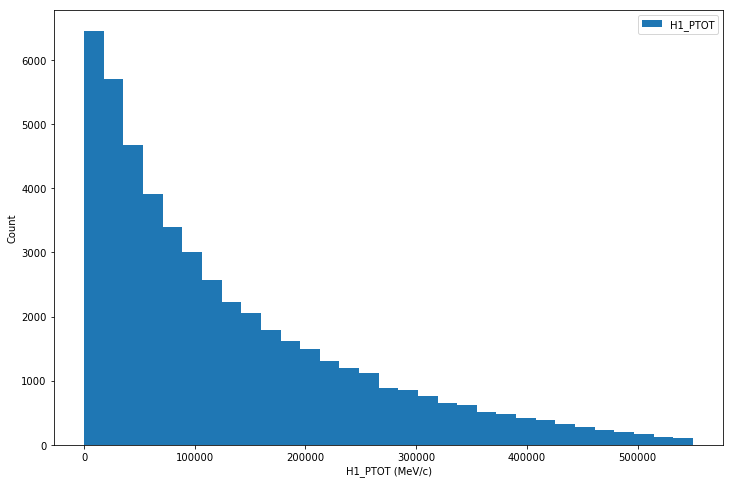

In [12]:
# calculate a variable for the magnitude of the momentum of the first kaon 
# plot a histogram of this variable

h1ptot_data_plot = p_tot.select("H1_PTOT").toPandas().plot.hist(bins=31, range=[0, 550000]) 
xlabel('H1_PTOT (MeV/c)')
ylabel('Count');

### Hints

**Histogram plotting** - You can use the hist() function. The parameters bins(n) and range(x,y) allow youto plot n bins over the range x to y.

**Vector Magnitude** The square magnitude of a magnitude of a vector is given by the sum of the square of its of its components in the x,y and z directions: $p^2 = p_x^2+p_y^2+p_z^2$, where $p$ is the magnitude of the momentum, and $p_x,p_y,p_z$ are the components of the momentum in the X,Y, and Z directions.

## Energy and mass

Einstein's theory of special relativity relates Energy, mass and momentum. We have measured the momentum of the kaon candidates in the detector, and have just plotted one of the components of the momentum of the kaon, and the magnitude of the momentum. The invariant mass of the kaon is well known and you can look this up. We wish to determine the energy of the kaons.    

Here is a brief guide to the energy-momentum relation of [special relativity](https://github.com/lhcb/opendata-project/tree/master/Background-Information-Notebooks/SpecialRelativity.ipynb). Further information can be found on wikipedia pages on [Invariant Mass](https://en.wikipedia.org/wiki/Invariant_mass)  and the [Energy-momentum relation](https://en.wikipedia.org/wiki/Energy%E2%80%93momentum_relation).

Now, calculate the energy of the first kaon candidate using:

<center> $E^2 = p^2 + m^2$ </center>

In [13]:
# Computes the Energy of the kaon candidates using the formula of special relativity
# that is including the magnitude of the momentum and invariant mass

kcharged_mass = 493.677

Energy_H1 = spark.sql("""
   select round(sqrt({0} + H1_PX*H1_PX + H1_PY*H1_PY + H1_PZ*H1_PZ),2) H1_Energy
   from sim_data 
   where H1_PROBK = 1.0
   """.format(kcharged_mass*kcharged_mass))

Energy_H1.show(5)

+---------+
|H1_Energy|
+---------+
| 24226.99|
| 36300.98|
|  8275.53|
|222845.62|
|  22300.9|
+---------+
only showing top 5 rows



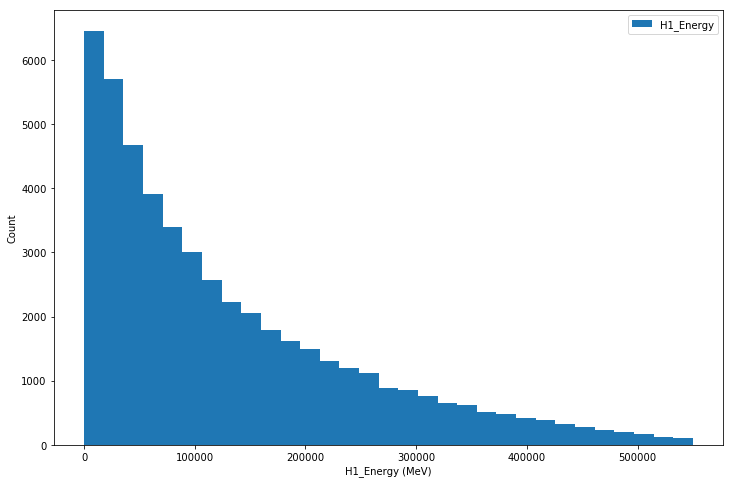

In [14]:
# Plots a histogram of the energy of the first kaon candidate

Energy_H1_data_plot = Energy_H1.toPandas().plot.hist(bins=31, range=[0, 550000]) 
xlabel('H1_Energy (MeV)')
ylabel('Count');

### Hints

**Energy calculation** - Use the magnitude of momentum variable you calculated above and the known invariant mass of the kaon to work out the energy of the first hadron. Calculate the energy squared, and then the energy and plot this.

**Kaon mass** - you can find the kaon mass on wikipedia or in physics textbooks. There is also a reference used by particle physicists: all our knowledge of the properties of the particles are collected together by the particle data group  [here](http://pdg.lbl.gov/2014/reviews/rpp2014-rev-charged-kaon-mass.pdf).

Calculate the momenta and energies of the second and third kaon candidates also.


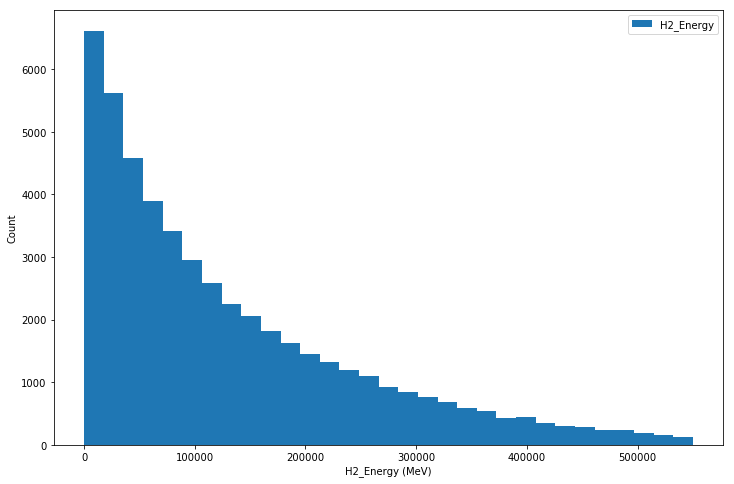

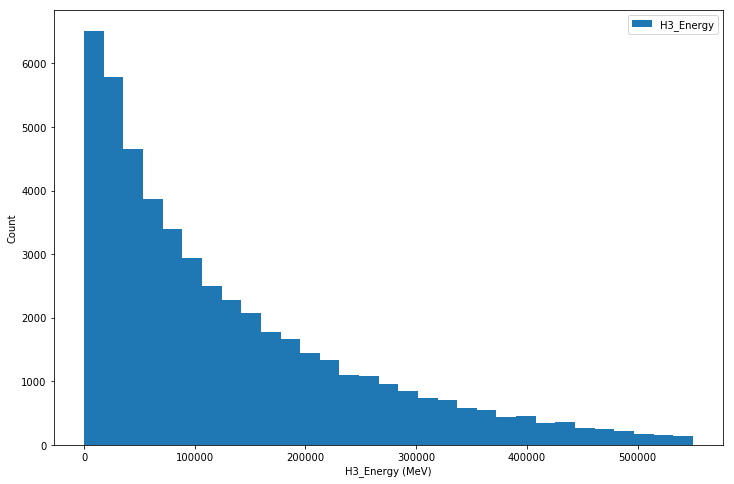

In [15]:
# calculate variables for the energy of the other two kaons

kcharged_mass = 493.677

Energy_H2 = spark.sql("""
   select sqrt({0} + H2_PX*H2_PX + H2_PY*H2_PY + H2_PZ*H2_PZ) H2_Energy
   from sim_data 
   where H2_PROBK = 1.0
   """.format(kcharged_mass*kcharged_mass))

Energy_H3 = spark.sql("""
   select sqrt({0} + H3_PX*H3_PX + H3_PY*H3_PY + H3_PZ*H3_PZ) H3_Energy
   from sim_data 
   where H3_PROBK = 1.0
   """.format(kcharged_mass*kcharged_mass))

Energy_H2_data_plot = Energy_H2.toPandas().plot.hist(bins=31, range=[0, 550000]) 
xlabel('H2_Energy (MeV)')
ylabel('Count')
Energy_H3_data_plot = Energy_H3.toPandas().plot.hist(bins=31, range=[0, 550000]) 
xlabel('H3_Energy (MeV)')
ylabel('Count');

## Adding features of the $B$ meson

In this analysis we are looking for B<sup>+</sup> or B<sup>-</sup> mesons (see [B meson](https://en.wikipedia.org/wiki/B_meson)) that have decayed into the three charged [kaons](https://en.wikipedia.org/wiki/Kaon).

Energy is a conserved quantities. This means that you can use the energy of the three 'daughter' kaons, which you have calculated above, to calculate the energy that the B meson that decayed into them must have.

Momentum is also a conserved quantity. Hence you can also use the momenta of the 'daughter' kaons to calculate the momentum of the B meson. But be careful - momentum is a *vector* quantity. 

Using the Energy of the B meson and the magnitude of the momentum of the B meson you can use the energy-momentum relationship again. This time you are applying it to the B meson. This will allow you to calculate the invariant mass of the B meson.


In [16]:
# calculate the energy of the B meson from the sum of the energies of the kaons

sum_kaons_energy = sql("""
  select 
    sqrt({0} + H1_PX*H1_PX + H1_PY*H1_PY + H1_PZ*H1_PZ)  +
    sqrt({0} + H2_PX*H2_PX + H2_PY*H2_PY + H2_PZ*H2_PZ)  +
    sqrt({0} + H3_PX*H3_PX + H3_PY*H3_PY + H3_PZ*H3_PZ)  as Tot_Energy    
  from sim_data
  where H1_ProbK = 1.0 and H2_ProbK = 1.0 and H3_ProbK = 1.0""".format(kcharged_mass*kcharged_mass))

sum_kaons_energy.show(10)

+------------------+
|        Tot_Energy|
+------------------+
| 657116.5757740112|
| 731372.0511105937|
|106495.84886114487|
| 425265.3012500729|
|  338761.408158081|
|175425.84880753706|
| 196160.8705834044|
| 794379.0808414945|
| 661607.1394124703|
| 725138.8031006289|
+------------------+
only showing top 10 rows



In [17]:
# Calculate the momentum components of the B meson 
# This is a vector sum (i.e. we sum each vector component of the kaons)

sum_kaons_momentum = sql("""
  select 
     H1_PX + H2_PX + H3_PX as PX_Tot,
     H1_PY + H2_PY + H3_PY as PY_Tot,
     H1_PZ + H2_PZ + H3_PZ as PZ_Tot
  from sim_data
  where H1_ProbK = 1.0 and H2_ProbK = 1.0 and H3_ProbK = 1.0""")

sum_kaons_momentum.show(10)

+------------------+------------------+------------------+
|            PX_Tot|            PY_Tot|            PZ_Tot|
+------------------+------------------+------------------+
| 81159.39000000001|34164.380000000005|         651168.39|
|-54357.21000000001|        -118454.64| 719646.4400000001|
|          -15596.0|15711.460000000001|         104035.62|
|           7482.21|           2216.05|425161.00000000006|
|          -2248.65|         -11608.84|         338513.81|
|305.62000000000006|         -38778.21|         171004.43|
|          20106.33| 6091.150000000001|194961.15000000002|
|         -43942.38|          -9465.89|         793088.72|
|          -3945.83|          33592.15|         660722.88|
|          28585.38|169779.41999999998|         704385.04|
+------------------+------------------+------------------+
only showing top 10 rows



In [18]:
# Calculate the momentum components of the B meson 
# This computes the vector magnitude of the vector computed above
# we use the spark sql declarative interface as opposed to writing an SQL statement for this
# the two approaches are equivalent in Spark

sum_kaons_momentum_magnitude = sum_kaons_momentum.selectExpr("sqrt(PX_Tot*PX_Tot + PY_Tot*PY_Tot + PZ_Tot*PZ_Tot) as P_Tot")

sum_kaons_momentum_magnitude.show(10)

+------------------+
|             P_Tot|
+------------------+
| 657095.3687107745|
| 731352.9972736745|
|106364.91630286745|
| 425232.6072458304|
|338720.26977091905|
|175346.39447109654|
|196089.81774613875|
| 794361.5383594519|
| 661588.0336519893|
|    725120.9967868|
+------------------+
only showing top 10 rows



In [19]:
# calculate the B meson invariant mass
# plot the B meson invariant mass in a histogram

b_meson_4momentum = sum_kaons_energy = sql("""
  select 
    sqrt({0} + H1_PX*H1_PX + H1_PY*H1_PY + H1_PZ*H1_PZ)  +
    sqrt({0} + H2_PX*H2_PX + H2_PY*H2_PY + H2_PZ*H2_PZ)  +
    sqrt({0} + H3_PX*H3_PX + H3_PY*H3_PY + H3_PZ*H3_PZ)  as Tot_Energy,
    H1_PX + H2_PX + H3_PX as PX_Tot,
    H1_PY + H2_PY + H3_PY as PY_Tot,
    H1_PZ + H2_PZ + H3_PZ as PZ_Tot
  from sim_data
  where H1_ProbK = 1.0 and H2_ProbK = 1.0 and H3_ProbK = 1.0""".format(kcharged_mass*kcharged_mass))

b_meson_4momentum.show(5)

+------------------+------------------+------------------+------------------+
|        Tot_Energy|            PX_Tot|            PY_Tot|            PZ_Tot|
+------------------+------------------+------------------+------------------+
| 657116.5757740112| 81159.39000000001|34164.380000000005|         651168.39|
| 731372.0511105937|-54357.21000000001|        -118454.64| 719646.4400000001|
|106495.84886114487|          -15596.0|15711.460000000001|         104035.62|
| 425265.3012500729|           7482.21|           2216.05|425161.00000000006|
|  338761.408158081|          -2248.65|         -11608.84|         338513.81|
+------------------+------------------+------------------+------------------+
only showing top 5 rows



In [20]:
b_meson_invariant_mass = b_meson_4momentum.selectExpr("""
   sqrt(Tot_Energy* Tot_Energy - (PX_Tot*PX_Tot + PY_Tot*PY_Tot + PZ_Tot*PZ_Tot) ) as invariant_mass""")
   
b_meson_invariant_mass.show(5)

+------------------+
|    invariant_mass|
+------------------+
| 5279.259021223659|
|5279.2541641354055|
| 5279.242799854169|
| 5273.156761236732|
| 5279.252178269909|
+------------------+
only showing top 5 rows



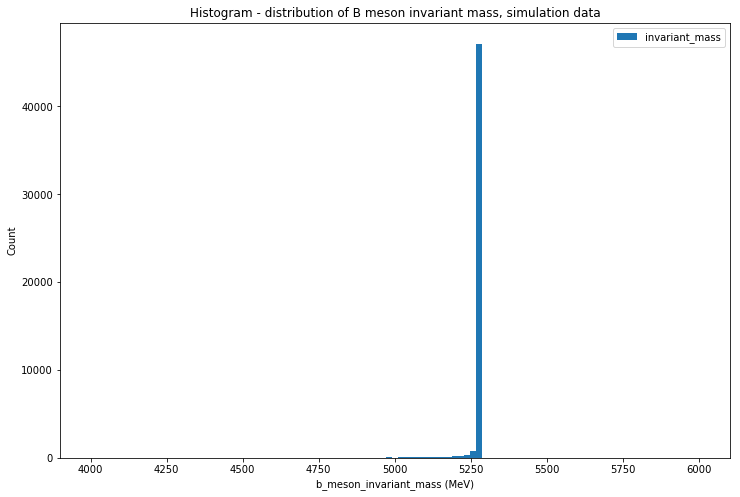

In [21]:
b_meson_invariant_mass.toPandas().plot.hist(bins=101, range=[4000, 6000],
title="Histogram - distribution of B meson invariant mass, simulation data") 
xlabel('b_meson_invariant_mass (MeV)')
ylabel('Count');

# Note the mass of the charged B meson is expected to be 5279.29±0.15 and this is consistenet with the 
# the peak in found in the data plotted here

You should have a graph that sharply peaks at the mass of the B<sup>+</sup> meson. The mass of the B<sup>+</sup> and B<sup>-</sup> meson are the same. Check that the peak of your graph is at the [known mass](http://pdg.lbl.gov/2014/listings/rpp2014-list-B-plus-minus.pdf) of the B meson. **Congratulations!**

Recall that you have made this plot for simulated data. How might you expect the plots for real data to look different ? In the next section you will start to work with the real LHC data.

### Hint

**B Meson Energy** - From energy conservation, the energy of the B meson will be the sum of the energies of the three kaons: $E_B=E_{K1}+E_{K2}+E_{K3}$, where $E_B$ is the energy of the B meson, $E_{K1}, E_{K2}, E_{K3}$ are the energies of each of the kaons. 

**B meson momentum** - From momentum conservation, the X component of the momentum of the B meson will be the sum of the X momentum components of the three Kaons : $px_B=px_{K1}+px_{K2}+px_{K3}$, where $px$ is the X direction component of the momentum of the B meson, $px_{K1},px_{K2},px_{K3}$ are the X direction components of the momenta of the three kaons. You can then do the same with the Y and Z components. Having obtained the X,Y, and z components of the B momentum you can find the magnitude of the momentum of the B meson.

** B meson invariant mass*** - Rearrange the equation $E^2=p^2+m^2$ to find $m^2$. Using the values of the magnitude of the momentum of the B meson and the B meson Energy, find the mass of the B meson.

**Histogram plotting** - Take care that the range of your mass plot is set suitably that you can see the mass peak. Once you have found the peak you can set the range appropriately. You do not have to start your graph at a mass of 0.

**Units** - The data you are provided has energies in 'MeV' (10<sup>6</sup> electron volts). The mass of the B meson is often quoted in 'GeV/c<sup>2</sup>' (10<sup>9</sup> electron volts).

# Working with real data and applying cuts
## Aims:
* Filter out data that is not from the B<sup>+</sup> → K<sup>+</sup>K<sup>+</sup>K<sup>−</sup> channel, or the antiparticle equivalent B<sup>-</sup> → K<sup>+</sup>K<sup>-</sup>K<sup>−</sup>

* Plot a histogram of B-meson mass for the real data and observe how different cuts affect the data

In the section above you have analysed the simulation data to determine the invariant mass of the B meson. Now, you can start applying the methods you have used to the real LHCb data. This data was collected by the LHCb detector at CERN during 2011, the first major year of LHC operations.

The data you are given has been filtered to select only events that are likely to have come from B<sup>+</sup> or B<sup>-</sup> mesons decaying into three final state charged particles. You are interested in the case where these three final state paticles are charged kaons K<sup>+</sup> or K<sup>-</sup>.

An introduction has been provided on the [detector and data sample](https://github.com/lhcb/opendata-project/tree/master/Background-Information-Notebooks/DetectorSoftwareDataSample.ipynb). As background information we also provide further information on the [selection](https://github.com/lhcb/opendata-project/tree/master/Background-Information-Notebooks/DataSelection.ipynb) that has been applied to select this data sample.

## Preselection
You want to apply a preselection to the three final state tracks that
* Ensures that they are not muons (i.e. `!H1_isMuon` where `!` means `not`, and similarly for `H2` and `H3`)
* Requires that they each have a low probability of being pions (e.g. `H1_ProbPi < 0.5`)
* Requires that they each have a high probability of being a kaon (e.g. `H1_ProbK > 0.5`)

You need to find a balance between making cuts that are too loose and include too many background events and too tight and reject many of your signal events.

In order to now find the most suitable further selection cuts, make yourself familiar with [how cuts can affect the significance of the final result](https://github.com/lhcb/opendata-project/tree/master/Background-Information-Notebooks/CutsInformation.ipynb). Feel free to come back to this stage later and adjust your cuts to see the impact. 

The pre selection you create will be applied for you if give it the name 'preselection'.

We have provided an example preselection in the hints, so feel free to use that to get started if you wish. start with a loose preselection and then refine it after you have studied the plots.



In [22]:
# Create the DataFrames with ROOT data using the spark-root data format
# Only metadata is read at this stage (reading into Spark DatFrames is lazily executed)

B2HHH_MagnetDown_df = spark.read.format("org.dianahep.sparkroot").load(data_directory + "B2HHH_MagnetDown.root")
B2HHH_MagnetUp_df = spark.read.format("org.dianahep.sparkroot").load(data_directory + "B2HHH_MagnetUp.root")


In [23]:
# Put all the data together
B2HHH_AllData_df = B2HHH_MagnetDown_df.union(B2HHH_MagnetUp_df)

In [24]:
# This defines the cut criteria
# You can experiment with different criteria

preselection = """H1_ProbPi < 0.5 and H2_ProbPi < 0.5 and H3_ProbPi < 0.5 
      and H1_ProbK > 0.5 and H2_ProbK > 0.5 and H3_ProbK > 0.5 
      and H1_isMuon = 0 and H2_isMuon = 0 and H3_isMuon = 0"""

# Apply cuts to the data as a filter 
B2HHH_AllData_WithCuts_df = B2HHH_AllData_df.filter(preselection)

In [25]:
# This *may take a few minutes* as data will be read at this stage

B2HHH_AllData_WithCuts_df.cache()  # flags the DataFrame for caching, this is useful for performance
B2HHH_AllData_WithCuts_df.count()  # triggers an action, data will be read at this stage

23895

In [26]:
# This registers the dataframe with cuts (filters) as a view for later use with SQL
B2HHH_AllData_WithCuts_df.createOrReplaceTempView("B2HHH_AllData_WithCuts")

In [27]:
# Displays a sample of the data
B2HHH_AllData_WithCuts_df.limit(10).toPandas()

,B_FlightDistance,B_VertexChi2,H1_PX,H1_PY,H1_PZ,H1_ProbK,H1_ProbPi,H1_Charge,H1_IPChi2,H1_isMuon,...,H2_IPChi2,H2_isMuon,H3_PX,H3_PY,H3_PZ,H3_ProbK,H3_ProbPi,H3_Charge,H3_IPChi2,H3_isMuon
0,6.888037,8.426947,1207.753798,-84.290958,10399.473702,0.902219,0.041574,-1,998.424410,0,...,110.519068,0,1973.085892,-289.150032,26771.341608,0.915843,0.057261,1,386.493713,0
1,8.957103,3.474719,-811.617861,-518.300956,22338.883014,0.942885,0.093401,1,162.677006,0,...,1994.119734,0,-4801.397918,1993.340031,76466.229808,0.806471,0.385119,-1,158.823018,0
2,9.100733,4.113123,-2007.925735,-2555.080382,26601.465958,0.917661,0.077237,-1,1355.611615,0,...,8500.518262,0,-1260.859080,-2824.663002,22365.178510,0.947676,0.097263,1,352.235461,0
3,11.077374,2.360357,1408.170513,-1372.864558,66357.093308,0.785618,0.119467,-1,2.799029,0,...,564.019813,0,2171.855775,-1964.419835,92096.742555,0.560237,0.070540,1,44.498271,0
4,17.743006,5.116309,1457.671574,1311.684099,8551.692070,0.783945,0.029395,1,18266.642863,0,...,1098.894225,0,10985.230400,1271.856077,62682.682662,0.576559,0.455894,-1,360.444011,0
5,11.554098,1.120899,-77.919930,598.047768,18486.604881,0.937157,0.227115,1,89.128636,0,...,2387.913090,0,-3786.001956,-3050.190096,49924.677288,0.940656,0.096659,-1,827.264326,0
6,8.296893,7.380471,970.351808,-490.045926,27929.242265,0.966135,0.095613,1,135.543971,0,...,944.174083,0,1618.033440,-1593.587768,45253.841121,0.959964,0.098093,-1,260.910241,0
7,15.875883,1.656760,2336.165388,4166.002188,35728.525679,0.946878,0.060513,-1,3321.946818,0,...,1942.129052,0,-1708.189185,2517.048779,27592.747481,0.961387,0.125535,1,7027.069112,0
8,12.265774,5.394378,2606.155962,-4657.669797,99824.722050,0.755108,0.403123,1,153.705895,0,...,4.976051,0,961.067631,892.008741,12739.165721,0.630626,0.030043,-1,4351.779561,0
9,7.960260,9.528332,-1740.175238,1060.634895,76542.224969,0.823950,0.096627,-1,28.678577,0,...,309.280125,0,-2026.920178,887.978374,47609.309664,0.972340,0.161073,1,193.376446,0


Make histograms of the probability of a final state particle being a kaon or a pion.
These will help guide you on suitable probability values at which to cut.

You can also consider more sophisticated options like 2-D plots of kaon and pion probabilities or different values of the cuts for the different final state particles.

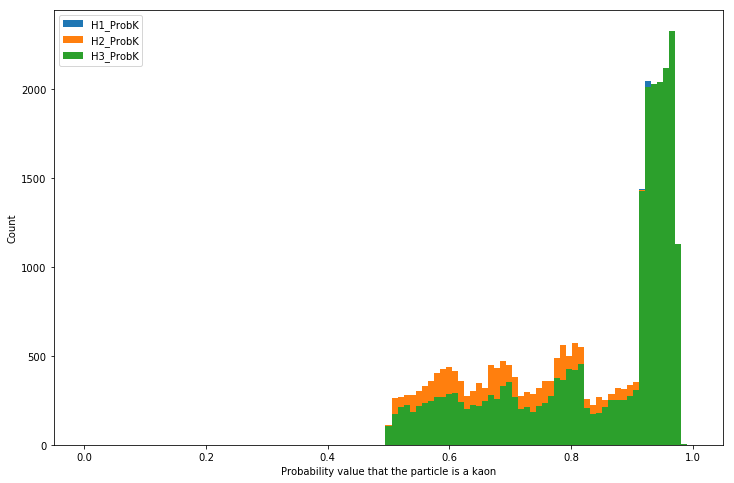

In [28]:
# plot the probability that a final state particle is a kaon

B2HHH_AllData_WithCuts_df.select("H1_ProbK", "H2_ProbK", "H3_ProbK").toPandas().plot.hist(bins=101, range=[0.0, 1.0])
xlabel('Probability value that the particle is a kaon')
ylabel('Count');

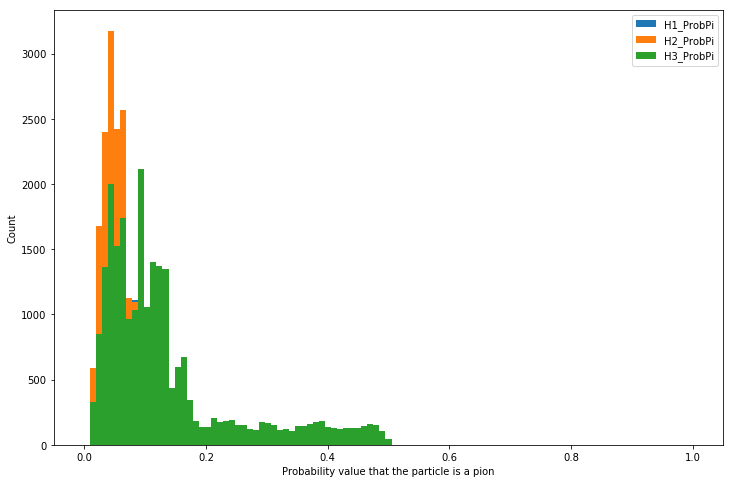

In [29]:
# plot the probability that a final state particle is a pion
B2HHH_AllData_WithCuts_df.select("H1_ProbPi", "H2_ProbPi", "H3_ProbPi").toPandas().plot.hist(bins=101, range=[0.0, 1.0])
xlabel('Probability value that the particle is a pion')
ylabel('Count');

Now calculate the invariant mass of the B meson for the real data and plot a histogram of this. 
Compare it with the one you drew for the simulation data. 

Can you explain the differences you observe?

In [30]:
# calculate the B meson invariant mass
# plot the B meson invariant mass in a histogram
b_meson_4momentum_withcuts = sql("""
  select 
     sqrt({0} + H1_PX*H1_PX + H1_PY*H1_PY + H1_PZ*H1_PZ)  +
     sqrt({0} + H2_PX*H2_PX + H2_PY*H2_PY + H2_PZ*H2_PZ) +
     sqrt({0} + H3_PX*H3_PX + H3_PY*H3_PY + H3_PZ*H3_PZ) as Tot_Energy,
     H1_PX + H2_PX + H3_PX as PX_Tot,
     H1_PY + H2_PY + H3_PY as PY_Tot,
     H1_PZ + H2_PZ + H3_PZ as PZ_Tot
  from B2HHH_AllData_WithCuts""".format(kcharged_mass*kcharged_mass))

b_meson_4momentum_withcuts.createOrReplaceTempView("b_meson_4momentum_mycuts_read_data")
b_meson_4momentum_withcuts.show(5)

+------------------+-------------------+-------------------+------------------+
|        Tot_Energy|             PX_Tot|             PY_Tot|            PZ_Tot|
+------------------+-------------------+-------------------+------------------+
| 86162.89710374283|  1916.065670301517|  77.15992169481359| 85981.36256238335|
|116710.00497921911| -7144.666830516883| -15.24835325482104|116369.28397058396|
| 64528.29362291747|-1575.5401941634025|-7543.4895996123105| 63848.13679774214|
| 207873.7078340979|  1924.019093047381| -3781.162863847703|207762.59892769693|
|117052.18424146794| 18764.329326458574|   2844.36565135338|115392.75963356277|
+------------------+-------------------+-------------------+------------------+
only showing top 5 rows



In [31]:
b_meson_invariant_mass_withcuts = b_meson_4momentum_withcuts.selectExpr("""
   sqrt(Tot_Energy* Tot_Energy - (PX_Tot*PX_Tot + PY_Tot*PY_Tot + PZ_Tot*PZ_Tot) ) as invariant_mass""")
   
b_meson_invariant_mass_withcuts.show(5)

+------------------+
|    invariant_mass|
+------------------+
| 5250.987328087266|
|5326.2100776796615|
| 5284.840877393883|
| 5308.658345711811|
| 5053.156322435298|
+------------------+
only showing top 5 rows



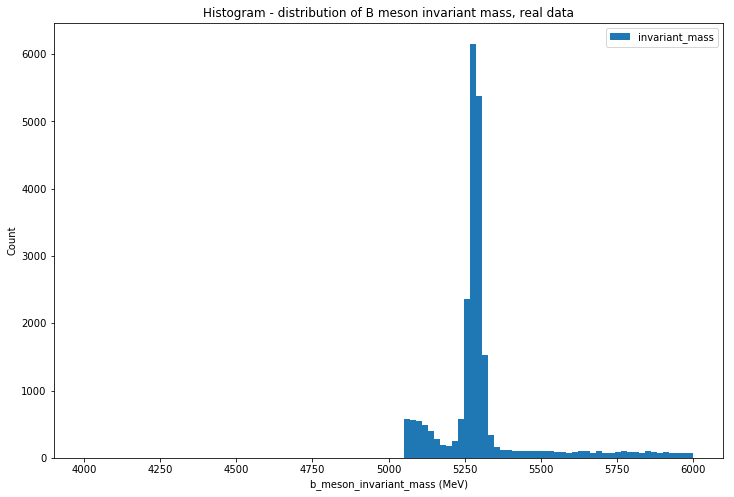

In [32]:
# draw a histogram for the B meson mass in the real data

b_meson_invariant_mass_withcuts.toPandas().plot.hist(bins=101, range=[4000, 6000],
title="Histogram - distribution of B meson invariant mass, real data") 
xlabel('b_meson_invariant_mass (MeV)')
ylabel('Count');


Additional exercise: Experiment with the cuts and see the impact of harsher or more lenient cuts on the invariant mass plot.
You should select a set of cuts which makes the signal most prominent with respect to the background.
Once you have finalised the selection on particle identification also make cuts on the reconstructed particle mass to select the events in the B meson mass peak, removing the background events which lie at lower and higher invariant masses. 

# Searching for global matter anti-matter differences

In this section you will start to study matter antimatter differences (CP Violation). Here 'global' means that you are looking for differences across all ranges of energy and momentum (the kinematics) of the kaons into which the charge B mesons have decayed. Later we look at 'local' differences in different regions of the kinematics. 

## Aims:
* Calculate the global CP asymmetry 
* Work out the statistical uncertainty
* Determine if there is evidence for CP violation in this decay

In order to quantify the matter antimatter asymmetry in this process we wish to compare the B<sup>+</sup> and the B<sup>-</sup> particles. The B<sup>-</sup> is the anti-particle of the B<sup>+</sup>.

How can you distinguish between events that contain B<sup>+</sup> and B<sup>-</sup> particles using `H1_Charge`, `H2_Charge` and `H3_Charge`?

In [33]:
# make a variable for the charge of the B mesons

B_charge_df = B2HHH_AllData_WithCuts_df.selectExpr("H1_charge + H2_charge + H3_charge as B_Charge")

Now count the numbers of events of each of the two types (N<sup>+</sup> and N<sup>-</sup>). Also calculate the difference between these two numbers.

In [34]:
# make variables for the numbers of positive and negative B mesons

# I am using the declarative API of Spark SQl for this. If you want to use SQL you can do the following:
# B_charge_df.createOrReplaceTempView("B_charge_table")
# sql("select B_Charge, count(*) from B_charge_table group by B_Charge").show(5)

B_charge_df.groupBy("B_Charge").count().show()


+--------+-----+
|B_Charge|count|
+--------+-----+
|      -1|11505|
|       1|12390|
+--------+-----+



In order to calculate the Asymmetry, you can make use of the formula:
(note you may need to run this box in order to see the image)
<img src="https://github.com/lhcb/opendata-project/raw/master/Images/AsymmetryEq.png" width="200" />

In [35]:
# calculate the value of the asymmetry, by using the formula above, and then print it

N_plus = 12390.0
N_minus = 11505.0
A =  (N_minus - N_plus) / (N_minus + N_plus)
A

-0.037037037037037035

### Hint

**Differentiating between N+ and N-**

 - Charge is a conserved quantity. The charge of the $B$ meson is equal to the sum of the charges of the particles into which it decays.
 - You can use ` len(real_data.query('B_Charge == charge'))` to count the number of mesons, where `B_Charge` is the variable you created and `charge` is `1` or `-1`.
 - You can find an example of this at the end of the example notebook.

### Estimating the significance of the deviation

You will now need to calculate the statistical uncertainty of the asymmetry. You can do so using the formula: <img src="https://github.com/lhcb/opendata-project/raw/master/Images/AsymmetryErrorEq.png" width="200" />

The significance of the result, sigma, is found by dividing the value for asymmetry by its uncertainty. A value exceeding three sigma is considered "evidence" by particle physicists while a value of five sigma or more can be called an "observation" or "discovery".

In [36]:
# calculate the statistical significance of your result and print it

sqrt((1 - A*A)/(N_minus + N_plus))

0.0064647004792617382

**Congratulations!** You have performed your first search for a matter anti-matter difference.

Here you have only considered the statistical uncertainty. Your measurement will also have other sources of uncertainty known as systematic uncertainties which you have not considered at this stage.


# Dalitz plots and two body resonances
## Aims:
* Produce Dalitz plots of the simulation and real data sample
* Create ordered and binned dalitz plots.
* Identify two body resonances in the Dalitz plots

In this stage we introduce you to an important technique for analysing decays of one particle (your charged B meson) into three bodies (the three kaons). This is known as a Dalitz plot. 

The decay of the B meson can proceed either directly to the three-body final state or via an intermediate particle. For example, B<sup>+</sup> → K<sup>+</sup>K<sup>+</sup>K<sup>−</sup>, could proceed through the decay  B<sup>+</sup> → K<sup>+</sup>R<sup>0</sup>, where R<sup>0</sup> is a neutral particle resonance which can decay R<sup>0</sup> → K<sup>+</sup>K<sup>-</sup>. Dalitz plots can be used to identify these resonances which are visible as bands on the Dalitz plot.

More information about these plots and why these are used in particle physics research can be found in [Dalitz Plot Introduction](https://github.com/lhcb/opendata-project/tree/master/Background-Information-Notebooks/DalitzPlots.ipynb).

The kinematics of a three-body decay can be fully described using only two variables. The energies and momenta of the three kaons are not independent of each other as they all come from the decay of a B meson and energy and momentum are conserved. The axes of the plots conventionally are the squared invariant masses of two pairs of the decay products. It is a 2D plot, the x and y axes are both squared masses and the density of points in the plot shows the structure.

Consider our decay B<sup>+</sup> → K<sup>+</sup><sub>1</sub>K<sup>+</sup><sub>2</sub>K<sup>−</sup><sub>3</sub>, where we have numbered the kaons 1,2,3 to distinguish them. We can calculate the invariant mass of three possible combinations that could correspond to intermediate resonances R<sup>++</sup><sub>1</sub> → K<sup>+</sup><sub>1</sub>K<sup>+</sup><sub>2</sub>, R<sup>0</sup><sub>2</sub> → K<sup>+</sup><sub>1</sub>K<sup>-</sup><sub>3</sub>, and R<sup>0</sup><sub>3</sub> → K<sup>+</sup><sub>2</sub>K<sup>-</sup><sub>3</sub>. 

The potential R<sup>++</sup><sub>1</sub> would be a doubly charged resonance. We would not expect to see any resonances corresponding to this as mesons are composed of one quark and one anti-quark and their charges cannot add up to two units.

The potential R<sup>0</sup><sub>2</sub> and R<sup>0</sup><sub>3</sub> correspond to configurations in which we could see resonances. Hence you should compute the invariant mass combinations for these. The square of these masses should be used as the Dalitz variables. 

We suggest you make these plots first for the simulation data. In the simulation there are no intermediate resonances and your plot should be of uniform density inside the range physically allowed by energy and momentum conservation.
	

In [37]:
# calculate the invariant masses for each possible hadron pair combination

two_body_resonances_df = sql("""
  select 
     sqrt({0} + H1_PX*H1_PX + H1_PY*H1_PY + H1_PZ*H1_PZ) +
     sqrt({0} + H2_PX*H2_PX + H2_PY*H2_PY + H2_PZ*H2_PZ) as Energy_K1_K2,
     sqrt((H1_PX + H2_PX)*(H1_PX + H2_PX) + (H1_PY + H2_PY)*(H1_PY + H2_PY) 
           + (H1_PZ + H2_PZ)*(H1_PZ + H2_PZ)) as P_K1_K2,
     sqrt({0} + H1_PX*H1_PX + H1_PY*H1_PY + H1_PZ*H1_PZ) +
     sqrt({0} + H3_PX*H3_PX + H3_PY*H3_PY + H3_PZ*H3_PZ) as Energy_K1_K3,
     sqrt((H1_PX + H3_PX)*(H1_PX + H3_PX) + (H1_PY + H3_PY)*(H1_PY + H3_PY) 
           + (H1_PZ + H3_PZ)*(H1_PZ + H3_PZ)) as P_K1_K3,
     sqrt({0} + H2_PX*H2_PX + H2_PY*H2_PY + H2_PZ*H2_PZ) +
     sqrt({0} + H3_PX*H3_PX + H3_PY*H3_PY + H3_PZ*H3_PZ) as Energy_K2_K3,
     sqrt((H2_PX + H3_PX)*(H2_PX + H3_PX) + (H2_PY + H3_PY)*(H2_PY + H3_PY) 
           + (H2_PZ + H3_PZ)*(H2_PZ + H3_PZ)) as P_K2_K3,
     H1_Charge, H2_Charge, H3_Charge
  from B2HHH_AllData_WithCuts""".format(kcharged_mass*kcharged_mass))

two_body_resonances_df.limit(5).toPandas()

,Energy_K1_K2,P_K1_K2,Energy_K1_K3,P_K1_K3,Energy_K2_K3,P_K2_K3,H1_Charge,H2_Charge,H3_Charge
0,59312.848237,59211.181509,37331.391551,37308.534012,75681.554420,75585.380172,-1,1,1
1,40065.665041,40022.232171,99009.419207,98975.411119,94344.925710,94244.771077,1,-1,-1
2,41944.817064,41751.672744,49387.243264,49369.614780,37724.526918,37581.719924,-1,1,1
3,115729.095355,115680.388609,158532.678053,158529.404702,141485.642261,141426.952947,-1,1,1
4,53399.569782,53304.215413,72440.132643,72359.081204,108264.666058,108244.552904,1,-1,-1


In [38]:
# Computes 2-body resonance invariant mass from two_body_resonances_df

two_body_resonances_invariant_mass_GeV_df = two_body_resonances_df.selectExpr( 
              "sqrt(Energy_K1_K2*Energy_K1_K2 - P_K1_K2*P_K1_K2) / 1000.0 as Mass_K1_K2", 
              "sqrt(Energy_K1_K3*Energy_K1_K3 - P_K1_K3*P_K1_K3) / 1000.0 as Mass_K1_K3",
              "sqrt(Energy_K2_K3*Energy_K2_K3 - P_K2_K3*P_K2_K3) / 1000.0 as Mass_K2_K3",
              "H1_Charge", "H2_Charge", "H3_Charge") 

two_body_resonances_invariant_mass_GeV_df.show(5)


+------------------+------------------+------------------+---------+---------+---------+
|        Mass_K1_K2|        Mass_K1_K3|        Mass_K2_K3|H1_Charge|H2_Charge|H3_Charge|
+------------------+------------------+------------------+---------+---------+---------+
| 3.471303828587013| 1.306171891413032| 3.814181901855551|       -1|        1|        1|
|1.8650595784143182| 2.594818979058174| 4.346047856093062|        1|       -1|       -1|
| 4.020634479824776| 1.319444470787454|3.2793686448023838|       -1|        1|        1|
|3.3572612179719226| 1.018751964103818| 4.074793973001933|       -1|        1|        1|
|3.1897761838303795|3.4258115164737077|2.0867877492976117|        1|       -1|       -1|
+------------------+------------------+------------------+---------+---------+---------+
only showing top 5 rows



In [39]:
# Two_body_resonances_invariant_mass_GeV_df.filter("H1_Charge * H2_Charge = -1").show()

two_body_resonances_invariant_mass_GeV_df.createOrReplaceTempView("t1")
sql("select H2_Charge * H3_Charge, count(*) from t1 group by H2_Charge * H3_Charge").show()

+-----------------------+--------+
|(H2_Charge * H3_Charge)|count(1)|
+-----------------------+--------+
|                      1|   23895|
+-----------------------+--------+



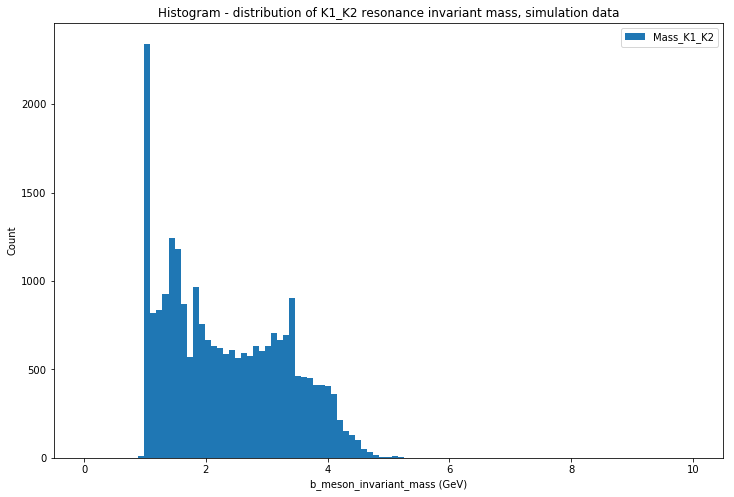

In [40]:
# plot the invariant mass for one of these combinations

two_body_resonances_invariant_mass_GeV_df.filter("H1_Charge + H2_Charge = 0").select("Mass_K1_K2") \
   .toPandas().plot.hist(bins=101, range=[0, 10],
title="Histogram - distribution of K1_K2 resonance invariant mass, simulation data") 
xlabel('b_meson_invariant_mass (GeV)')
ylabel('Count');


In [41]:
two_body_resonances_invariant_mass_GeV_df.filter("H1_Charge * H3_Charge = -1").count()

23895

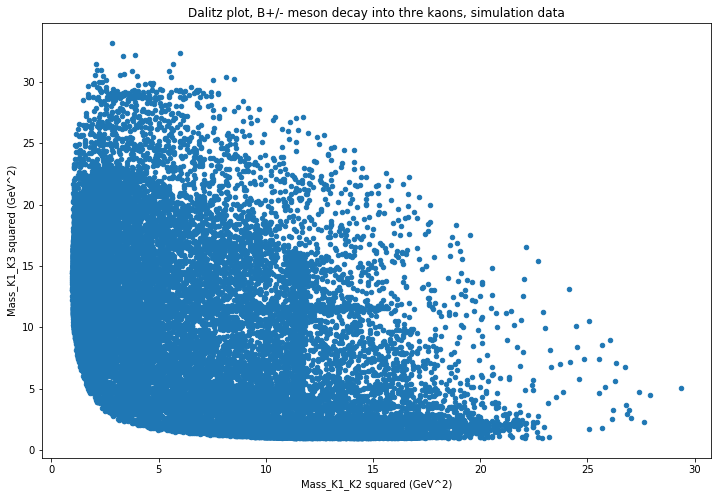

In [42]:
# Make a Dalitz plot with labelled axes for the simulation data

# This is achieved by plotting a scatter graph from Mass_12 squared vs. Mass_13 squared
# As in the text of the exercise, add a filter on data that the possible resonance has charge 0

dalitz_plot_df = two_body_resonances_invariant_mass_GeV_df \
                .filter("H1_Charge + H2_Charge = 0").filter("H1_Charge + H3_Charge = 0") \
                .selectExpr("Mass_K1_K2*Mass_K1_K2 as M12_squared", "Mass_K1_K3*Mass_K1_K3 as M13_squared")

dalitz_plot_df.toPandas().plot.scatter(x='M12_squared', y='M13_squared',
title="Dalitz plot, B+/- meson decay into thre kaons, simulation data")
xlabel('Mass_K1_K2 squared (GeV^2)')
ylabel('Mass_K1_K3 squared (GeV^2)');


### Hints

**Calculating invariant mass** - Use the same technique as you did above for the B meson, but now applying it to two-body invariant masses rather than three.

**Plotting the Dalitz plot** - You can use a `scatter` plot from `matplotlib` to plot a Dalitz plot, see the [example analysis](https://github.com/lhcb/opendata-project/tree/master/Example-Analysis.ipynb). Remember to use the square of each two-body mass.

## Adding Dalitz plot for real data
Now draw a Dalitz plot for the real data. Check that the signs of the charge of the hadrons are correct to correspond to your potential neutral resonances R<sup>0</sup><sub>2</sub> and R<sup>0</sup><sub>3</sub>.

In [43]:
# calculate the invariant masses for each possible hadron pair combination in the real data

In [44]:
# make a Dalitz plot for the real data (with your preselection cuts applied)

<div align="justify">While drawing the Dalitz plot for the real data, label the axes accordingly. Compare the Dalitz plots of the real data with the one for the simulation. 
What are the most striking differences? 
</div>

### Ordering Dalitz variables
You can make a further improvement to allow you to observe the resonances easier. Your resonances R<sup>0</sup><sub>2</sub> and R<sup>0</sup><sub>3</sub> are both composed of the same particle types, K<sup>+</sup>K<sup>-</sup>, and hence have the same distributions. It is useful to impose an ordering which distinguishes the resonances. We can call the resonances R<sup>0</sup><sub>Low</sub> and R<sup>0</sup><sub>High</sub>. In each event R<sup>0</sup><sub>Low</sub> is the resonance with the lower mass and the other corresponds to the higher mass combination of kaons. You can now use the mass of these ordered resonances as your Dalitz plot variables, thus effectively "folding" your Dalitz plot so that one axis always has a higher value than the other.


In [45]:
# make a new Dalitz plot with a mass ordering of the axes

### Hint

**Ordered Dalitz plot** - You can find the maximum of the mass of R<sup>0</sup><sub>Low</sub> vs R<sup>0</sup><sub>High</sub> elementwise on one axis, and the minimum of on the other. You can use `numpy.min(a,b)` and `numpy.max(a,b)` to perform elementwise comparisons between two arrays `a` and `b` and return one array filled by either the individual min/max element from the elementwise comparisons.

### Binned Dalitz plot
You can improve the representation of your Dalitz plot by binning the data. The hist2d function can be used to make a 2D histogram. The number of bins specification in the hist2d function is the number of bins in one axis.

In [46]:
# plot a binned Dalitz Plot
# use colorbar() to make a legend for your plot at the side

## Two body resonances

You can now use your Dalitz plot to identify the intermediate resonances that you see in your plots. The resonances will have shown up as bands of higher density of points on the plots. You can use the [particle data group](http://pdg.lbl.gov/2015/tables/contents_tables.html) tables of mesons to identify which particles these correspond to. The tables give the masses and widths of the particles and their decay modes. You are looking for mesons with the masses corresponding to where you see the bands and that decay into K<sup>+</sup>K<sup>-</sup>.

**Congratulations!** You have succesfully made a Dalitz plot and used it to observe the presence of intermediate particles in the decay of your charged B meson into three charged kaons. 

# Searching for local matter anti-matter differences
## Aims:
* Observe matter antimatter differences (CP violation) in regions of the Dalitz plots of the B<sup>+</sup> and B<sup>-</sup> mesons.
* For the data in these regions produce plots to best display the CP violation.

In a section above you searched for global CP violation. You probably did not find a result with very high significance. 

CP violation may arise from interference between decays through different resonances, and hence the magnitude and sign of the CP violation may vary across the Dalitz plot. We can apply the same equation as in the global CP violation study 
<img src="https://github.com/lhcb/opendata-project/raw/master/Images/AsymmetryEq.png" width="200" />
but apply this only to events in particular regions of the Dalitz plot.


## Removing charm resonances

The analysis performed here is to study the CP violation in the charmless B meson decays to kaons. "charmless" means that the decay does not proceed through a charm quark. However, the most frequent decay of the B mesons occur through the *b* quark decaying into a *c* quark. The majority of these events can be removed by rejecting the events that are proceeding through a D<sup>0</sup> meson (which contains the charm quark).

In the section above you plotted a histogram of the invariant mass of the intermediate resonances and will have observed the D<sup>0</sup> meson in this and in the Dalitz plot. You should now reject events that are around the mass range of the D<sup>0</sup> meson to suppress this contribution. You can do this in your pre-selection on the data that you set-up earlier in the project.

This was also a simplification that we did not consider when we were calculating the global asymmetry. After you have applied this pre-selection your code will now recompute the global asymmetry with the D<sup>0</sup> meson contribution rejected. We have not yet observed CP violation in charm mesons and searching for this is another active area of current research.

## Comparing Dalitz plots

Make separate Dalitz plots for the B<sup>+</sup> and the B<sup>-</sup> decays.
Local CP Violation will show up as an asymmetry between the B<sup>+</sup> and the B<sup>-</sup> plots.  

In order that the statistical error on the asymmetry in each bin is not over large the bins need to contain a reasonable number of entries. Hence you will probably need larger bins than when you were looking for resonances in the section above. A suitable initial bin size might be $2.5~\text{GeV}^2/\text{c}^4 \times 2.5~\text{GeV}^2/\text{c}^4$.


In [47]:
# make a Dalitz plot for the B+ events

In [48]:
# make a Dalitz plot for the B- events

In [49]:
# Make a plot showing the asymmetry between these two Daltz plots
# i.e. calculate the asymmetry between each bin of the B+ and B- Dalitz plots and show the result in another 2D plot

Observing a large asymmetry in some regions of the plot does not necessarily mean you have observed CP violation. If there are very few events in that region of the plot the uncertainty on that large asymmetry may be large. Hence, the value may still be compatible with zero.

You can calculate the statistical uncertainty on the asymmetry, for each bin of the plot, using the same formulas as you used in the global asymmetry section. You can then make a plot showing the uncertainty on the asymmetry.

Dividing the plot showing the asymmetry by the plot showing the statistical uncertainty you can then obtain the significance of the asymmetry in each bin. You can then plot the significance of the asymmetry to see if there is any evidence for CP violation.

In [50]:
# Make a plot showing the uncertainty on the asymmetry 

In [51]:
# Make a plot showing the statistical significance of the asymmetry

## Observing CP violation

From your studies of the asymmetry plot, and the plot of its significance, you will be able to identify regions in the Dalitz plots that show indications of sizeable and significant CP Violation. You may find you have several consecutive bins with significant positive, or negative, asymmetries. You may wish to try alternative binnings of the Dalitz plots to best isolate the regions in which the significant asymmetries occur.

You can select events that are in these regions of the Dalitz plots where you observe signs of CP Violation. You can then plot a simple 1D histogram of the invariant mass distribution of the B<sup>+</sup> and the B<sup>-</sup> events, just as you did at the start of the project, but only for events that lie in the region of the Dalitz plot that you are interested in. Make the plots of the B<sup>+</sup> and the B<sup>-</sup> events with the same scale, or superimpose the two plots, so that you can observe if the particle and anti-particle decay processes are occurring at the same rate.

In [52]:
# Make a plot showing the invariant mass of the B+ meson particles
# using events from a region of the Dalitz plot showing sizeable CP asymmetries

In [53]:
# Make a plot showing the invariant mass of the B- meson particles using events from the same region

**Congratulations!** You should now have succesfully observed significant evidence for CP Violation. You should have plots that clearly show that particle and anti-particle decay processes occur at different rates in local regions of the Dalitz plot. You may wish to comapre your results with those published by the LHCb collaboration in this [paper](http://lhcbproject.web.cern.ch/lhcbproject/Publications/LHCbProjectPublic/LHCb-PAPER-2013-027.html).

**Well Done** you have succesfully completed your first particle physics analysis project. There are many more analyses that can be conducted witht the data set that you have been provided and the skills that you have gained. Ideas for some of these are explored in the section below. Maybe you can discover something new!

Now you've finished the analysis please provide feedback to help us improve this project using [this brief survey](https://docs.google.com/forms/d/1dEh4A4agmk5zpmR0zrhF79k-lJKV4vX1ETIGJjDscnc/viewform?c=0&w=1).

# Further analyses

The data set you have been provided is the full set of data recorded by LHCb preselected for decays of charged B mesons into three final state tracks. This data set has been used for two important publications, [here](http://lhcbproject.web.cern.ch/lhcbproject/Publications/LHCbProjectPublic/LHCb-PAPER-2013-027.html) and [here](http://lhcbproject.web.cern.ch/lhcbproject/Publications/LHCbProjectPublic/LHCb-PAPER-2013-051.html).

We discuss here: 
<ul>
<li>Additional elements that you could add to your analysis of B<sup>+</sup> → K<sup>+</sup>K<sup>+</sup>K<sup>−</sup> </li>
<li>Further analyses that you could perform with this data set</li>
</ul>

## Adding extra sophistication

### Systematic Uncertainties
In this analysis you considered the statistical uncertainty on the result. This occurs as a result of having only a limited number of events. In addition there are [systematic uncertainties](https://en.wikipedia.org/wiki/Observational_error#Systematic_versus_random_error), these arise from biases in your measurement. Here we discuss three sources of these for this analysis.
<ul>
<li> Production asymmetry. The LHC is a proton-proton collider and hence the initial state of the collision is not matter antimatter symmetric. Consequently B<sup>+</sup> and B<sup>-</sup> mesons may not be produced at exactly the same rates. This small production asymmetry it is estimated could be approximately 1%. It can also be measured from the data, as discussed in the LHCb paper.</li>
<li> Detection asymmetry. The LHCb detector could be more efficient for detecting either the B<sup>+</sup> or the B<sup>-</sup> final states. This is because the positive and negative kaons will be bent by the magnet indifferent directions in the detector. If the efficiency of the detector is higher in one region than another this will lead to higher efficiencies for K<sup>+</sup> or K<sup>-</sup> and hence for B<sup>+</sup> or B<sup>-</sup>. For this reason the magnetic field of the LHCb detector is regularly reversed. You used data in this analysis in which the magnetic field was both up and down and hence the effect will (partially) cancel. By comparing results for the two magnet polarities separately you can check the size of this effect. When loading the data above both polarities were combined, you can instead load them independently to measure the difference between the two datasets.</li>
<li> Analysis technique. The analysis technique you have used may bias the result. A major simplification we made in the analysis above was to neglect 'background' events. We imposed a selection to select a sample of predominantly signal events but have not accounted for the effect of the residual background events.</li>
</ul>

### Using mass sidebands

One source of 'background' events arises from random combinations of tracks in events that happen to fake the 'signal' characteristics. These events will not peak in the mass distribution at the mass of the B meson but rtaher will have a smoothly varying distribution. Looking at the number and distribution of of events away from the mass peak can allow you to estimate the number of background events under the mass peak.

### Fitting distributions

The next level of sophistication in the analysis requires fitting the distributions of events that are observed in the B mass distribution in order to estimate the yield of signal events and background events. You can see how this is done in the LHCb paper on the analysis. Fitting can be performed using the [CERN root framework](https://root.cern.ch/).

## Further analyses

The LHCb papers using this data set that you are using analysed four decay channels of the charged B mesons. You can perform any of these analyses.
<ul>
<li>B<sup>+</sup> → K<sup>+</sup>K<sup>+</sup>K<sup>−</sup> (and anti-particle equivalent). This is the analysis you have performed here. It has the lowest background of the four channels and hence the approximation we made of neglecting the background events will give the least bias to this channel.</li>
<li>B<sup>+</sup> → &pi;<sup>+</sup>&pi;<sup>+</sup>&pi;<sup>−</sup> (and anti-particle equivalent). In this analysis the final state is three charged pions. The level of background events compared to the signal is significantly higher as pions are the most commonly produced particle at the LHC. Hence, a method of estimating the background level should be added to complete this analysis.</li>
<li>B<sup>+</sup> → K<sup>+</sup>&pi;<sup>+</sup>&pi;<sup>−</sup> (and anti-particle equivalent). In this analysis the final state is a mixture of one kaon and two pions. This means that the analysis needs to determine in each event which track is the best candidate kaon and apply selection cuts appropriately to select out the events.</li>
<li>B<sup>+</sup> → &pi;<sup>+</sup>K<sup>+</sup>K<sup>−</sup> (and anti-particle equivalent). This channel has a higher level of background compared to the signal.</li>
</ul>